In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pyproj
from scipy.interpolate import griddata
import cftime
from sklearn.linear_model import LinearRegression
import cartopy.feature as cfeature

In [3]:
home_path = os.path.expanduser("~")

path = '/DataFiles'
path2 = '/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - MacBook Air/Python/Ice Cores/data/model/ccsm4_last_millenium'

racmo = xr.open_dataset(home_path + path + "/smb_monthlyS_ANT27_ERA5-3H_RACMO2.3p2_197901_202212.nc")
mask = xr.open_dataset(home_path + path + "/TotIS_RACMO_ANT27_IMBIE2.nc")

In [10]:
# Extract coordinate arrays
lat_attr = np.array(mask.GroundedIce.attrs["lat2d"])
lon_attr = np.array(mask.GroundedIce.attrs["lon2d"])

# Reshape to 2D
nlat, nlon = mask.dims["lat"], mask.dims["lon"]
lats2d = lat_attr.reshape(nlat, nlon)
lons2d = lon_attr.reshape(nlat, nlon)

# Attach as coordinates
basins = mask["GroundedIce"].copy()
basins = basins.assign_coords(lat=(("lat", "lon"), lats2d),
                              lon=(("lat", "lon"), lons2d))

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_37475/630878015.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlat, nlon = mask.dims["lat"], mask.dims["lon"]


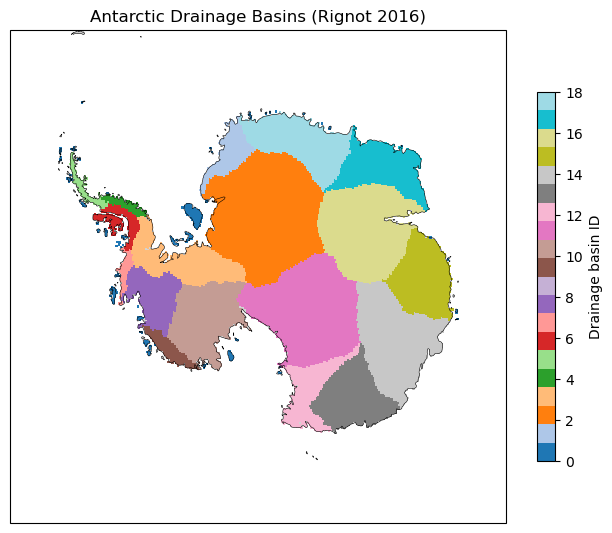

In [11]:
proj = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})
ax.set_extent([-180, 180, -90, -60], crs=data_crs)

ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Filled basins
im = ax.pcolormesh(
    basins.lon, basins.lat, basins,
    transform=data_crs,
    cmap='tab20'
)


plt.colorbar(im, ax=ax, shrink=0.6, label="Drainage basin ID")
ax.set_title("Antarctic Drainage Basins (Rignot 2016)", fontsize=12)
plt.show()